In [15]:
import sys
print("User Current Version:-", sys.version)

User Current Version:- 3.9.15 (main, Nov 24 2022, 14:39:17) [MSC v.1916 64 bit (AMD64)]


In [9]:
# o código a seguir tem o objetivo de carregar o arquivo contendo os dados após filtragem de linhas e colunas e após feature engeneering
import numpy as np
import pandas as pd

# carrega arquivo com dados filtrados
obj_raras_filtered = pd.read_csv(filepath_or_buffer='raras_retrospectivo_filtered.csv', sep=';', converters={"hpos": lambda x: x.strip("[]").split(", ")})
obj_raras_filtered = obj_raras_filtered.drop('Unnamed: 0', axis=1) # isso ou salvar com index=False

# undersampling da classe "Outros ORPHAs"
obj_raras_filtered = obj_raras_filtered.drop(obj_raras_filtered[obj_raras_filtered.diagnostico=="Outros ORPHAs"].sample(n=2000, random_state=1).index)

print(obj_raras_filtered.shape)
print(obj_raras_filtered.diagnostico.value_counts())
print(obj_raras_filtered.diagnostico.value_counts(normalize=True))
obj_raras_filtered.head(5)

(2919, 11)
Outros ORPHAs     1042
ORPHA 716.0        526
ORPHA 98896.0      194
ORPHA 803.0        156
ORPHA 442          152
ORPHA 636.0        150
ORPHA 881          150
ORPHA 586.0        111
ORPHA 315306       108
ORPHA 963.0         81
ORPHA 273.0         77
ORPHA 289326.0      64
ORPHA 324.0         54
ORPHA 232.0         54
Name: diagnostico, dtype: int64
Outros ORPHAs     0.356972
ORPHA 716.0       0.180199
ORPHA 98896.0     0.066461
ORPHA 803.0       0.053443
ORPHA 442         0.052073
ORPHA 636.0       0.051387
ORPHA 881         0.051387
ORPHA 586.0       0.038027
ORPHA 315306      0.036999
ORPHA 963.0       0.027749
ORPHA 273.0       0.026379
ORPHA 289326.0    0.021925
ORPHA 324.0       0.018499
ORPHA 232.0       0.018499
Name: diagnostico, dtype: float64


,diagnostico,hpos,consang_relatada,idade_materna_days,idade_paterna_days,raca_cor,sexo,regiao_nascimento,regiao_residencia,idade_inicio_sintomas_days,age_diag_days
2,ORPHA 273.0,"['HP:0002058', 'HP:0020034']",nao,NaN,9490.0,branca,feminino,sul,sul,20.0,NaN
3,Outros ORPHAs,"['HP:0010535', 'HP:0007957', 'HP:0002828', 'HP...",nao,8760.0,9855.0,branca,feminino,sul,sul,6.0,7449.0
4,ORPHA 315306,"['HP:0001007', 'HP:0000062']",nao,NaN,NaN,branca,feminino,sul,sul,0.0,NaN
5,ORPHA 315306,['HP:0000062'],NaN,NaN,NaN,preta,feminino,sul,sul,0.0,NaN
8,ORPHA 716.0,"['HP:0004923', 'HP:0001513']",nao,NaN,NaN,branca,masculino,sul,sul,11.0,NaN


In [10]:
# IMPORTAÇÃO DE BIBLIOTECAS E FUNÇÕES
# ferramentas básicas para manipular os dados
import numpy as np
import pandas as pd
import sklearn
# ferramenta para divisão de conjuntos de teste e treinamento
from sklearn.model_selection import train_test_split
# ferramentas para composição do fluxo dos dados
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# ferramentas para processamento dos dados
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing
# ferramentas para imputação de dados
from sklearn import impute
# classificadores
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import neural_network
from sklearn import linear_model
# grid para busca dos parâmetros ótimos
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV
# save the trained model
import joblib
# configurações de output e warning
import warnings
warnings.filterwarnings("ignore")
from sklearn import set_config
set_config(transform_output="pandas")
# manutenção de memória
import gc

# definido funções custom
class NanReplacer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.replace(np.nan, -1)
        else:
            assert isinstance(X, np.ndarray)
            where_are_NaNs = np.isnan(X)
            X[where_are_NaNs] = -1
            return X

class ColunmCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.loc[:,~X.columns.str.contains('_nan', case=False)]
            return X
    def fit_transform(self, X, y=None):
        return self.transform(X)

class EmptyHPOSCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            if 'multilabel_bin__' in X.columns:
                X = X.drop(['multilabel_bin__'], axis=1)
        return X
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MultiHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = None
        self.categories_ = self.classes_ = list()
    def fit(self, X:pd.DataFrame, y=None):
        self.mlb = preprocessing.MultiLabelBinarizer().fit(X)
        self.classes_ = self.mlb.classes_
        return self
    def transform(self, X:pd.DataFrame, y=None):
        result = self.mlb.transform(X)
        result = pd.DataFrame(
            data=result, 
            columns=self.classes_, 
            index=X.index
        )
        return result
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    def get_feature_names_out(self):
        return self.classes_

# PREPROCESSAMENTO DOS DADOS, TRANSFORMAÇÃO E ESCALA DE COLUNAS
# extrai coluna de classe e aplica label encoder
label_encoder = preprocessing.LabelEncoder()
y = obj_raras_filtered.diagnostico
obj_raras_filtered_nodiag = obj_raras_filtered.drop(columns=['diagnostico'])
y_encoded = label_encoder.fit_transform(y)

# separa os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(obj_raras_filtered_nodiag, y_encoded, test_size=0.25, stratify=y_encoded)

# separar as colunas com valores categóricos
categorical_features = [
    'consang_relatada',
    'raca_cor',
    'sexo',
    'regiao_nascimento',
    'regiao_residencia'
]

# separar as colunas com valores numéricos
numeric_features = [
    'idade_materna_days',
    'idade_paterna_days',
    'idade_inicio_sintomas_days',
    'age_diag_days'
]

#fazer onehot com e sem imputer
categorical_pipe_imputer = Pipeline(
    steps=[
        ('one_hot', preprocessing.OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
        ('clean_columns', ColunmCleaner()),
        ('imputer', impute.SimpleImputer())
    ]
)

categorical_pipe_no_imputer = Pipeline(
    steps=[
        ('one_hot', preprocessing.OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
        ('clean_columns', ColunmCleaner())
    ]
)

numeric_pipe_replacer = Pipeline(
    steps=[
        ('scaler', preprocessing.MinMaxScaler()),
        ('replacer', NanReplacer())
    ]
)

numeric_pipe_imputer = Pipeline(
    steps=[
        ('imputer', impute.SimpleImputer()),
        ('scaler', preprocessing.MinMaxScaler())
    ]
)

# aplica todos os transformadores nas colunas indicadas
proprocessing_ct = ColumnTransformer(
    transformers=[
        ('multilabel_bin', MultiHotEncoder(), 'hpos'),
        ('categorical_pipe', categorical_pipe_no_imputer, categorical_features),
        ('numeric_pipe', numeric_pipe_imputer, numeric_features)
    ],
    remainder='passthrough'
)

# pipeline de processamento, limpeza e classificação
classification_pipe = Pipeline(
    steps=[
        ('preprocessing_ct', proprocessing_ct),
        ('remove_hpo', EmptyHPOSCleaner()),
        ('classifier', neighbors.KNeighborsClassifier())
    ]
)

# cria dicionários de parâmetros para cada pipe de processadores e classificadores
numeric_scaler_params = [
        preprocessing.StandardScaler(),
        preprocessing.MinMaxScaler(), 
        preprocessing.RobustScaler(),
        preprocessing.MaxAbsScaler()
]

# parâmetros multilabel binalizer
param_mutilabe_bin = [
    {
        'preprocessing_ct__multilabel_bin': [MultiHotEncoder()]
    }
]

# parâmetros do processador categorico
param_categorical_pipe = [
    {
        'preprocessing_ct__categorical_pipe': [categorical_pipe_no_imputer]
    },
    {
        'preprocessing_ct__categorical_pipe': [categorical_pipe_imputer],
        'preprocessing_ct__categorical_pipe__imputer': [impute.SimpleImputer()],
        'preprocessing_ct__categorical_pipe__imputer__strategy': ['mean', 'median', 'most_frequent']
    },
    {
        'preprocessing_ct__categorical_pipe': [categorical_pipe_imputer],
        'preprocessing_ct__categorical_pipe__imputer': [impute.KNNImputer()],
        'preprocessing_ct__categorical_pipe__imputer__n_neighbors': [3, 5, 9],
        'preprocessing_ct__categorical_pipe__imputer__weights': ['distance', 'uniform']
    }
]

# parâmetros do processador numerico
param_numerical_pipe = [
    {
        'preprocessing_ct__numeric_pipe': [numeric_pipe_replacer],
        'preprocessing_ct__numeric_pipe__replacer': [NanReplacer()],
        'preprocessing_ct__numeric_pipe__scaler': numeric_scaler_params
    },
    {
        'preprocessing_ct__numeric_pipe': [numeric_pipe_imputer],
        'preprocessing_ct__numeric_pipe__imputer': [impute.SimpleImputer()],
        'preprocessing_ct__numeric_pipe__imputer__strategy': ['mean', 'median', 'most_frequent'],
        'preprocessing_ct__numeric_pipe__scaler': numeric_scaler_params
    },
    {
        'preprocessing_ct__numeric_pipe': [numeric_pipe_imputer],
        'preprocessing_ct__numeric_pipe__imputer': [impute.KNNImputer()],
        'preprocessing_ct__numeric_pipe__imputer__n_neighbors': [3, 5, 9],
        'preprocessing_ct__numeric_pipe__imputer__weights': ['distance', 'uniform']
    }
]

# parâmetros do classificador
param_classifier = [
    {
        'classifier': [neighbors.KNeighborsClassifier()],
        'classifier__algorithm': ['brute', 'kd_tree', 'ball_tree'],
        'classifier__p': [2, 1],
        'classifier__n_neighbors': [3, 5, 9],
        'classifier__weights': ['distance', 'uniform'],
    },
    {
        'classifier': [tree.DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy', 'log_loss'],
        'classifier__splitter': ['best', 'random'],
        'classifier__max_depth': [10, 20, 30, None]
    },
    {
        'classifier': [ensemble.RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy', 'log_loss'],
        'classifier__max_depth': [10, 30, None],
        'classifier__n_estimators': [10, 50, 100, 200]
    },
    {
        'classifier': [neural_network.MLPClassifier()],
        'classifier__activation': ['relu', 'identity', 'logistic', 'tanh'],
        'classifier__solver': ['adam', 'lbfgs', 'sgd'],
        'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
        'classifier__hidden_layer_sizes': [12, 20, 100],
        'classifier__early_stopping': [True]
    },
    {
        'classifier': [linear_model.LogisticRegression()],
        'classifier__C': [10**-2, 10**-1, 10**0, 10**1, 10**2],
        'classifier__penalty': ['l2', None], 
        'classifier__class_weight': [None, 'balanced'],
        'classifier__solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']
    },
    {
        'classifier': [linear_model.LogisticRegression()],
        'classifier__C': [10**-2, 10**-1, 10**0, 10**1, 10**2],
        'classifier__penalty': ['l1', 'l2'], 
        'classifier__class_weight': [None, 'balanced'],
        'classifier__solver': ['liblinear']
    },
    {
        'classifier': [linear_model.LogisticRegression()],
        'classifier__C': [10**-2, 10**-1, 10**0, 10**1, 10**2],
        'classifier__penalty': ['l1', 'l2', None, 'elasticnet'], 
        'classifier__class_weight': [None, 'balanced'],
        'classifier__l1_ratio': [0.1, 0.5, 0.9],
        'classifier__solver': ['saga']
    }
]

param_list = list()
for clfr in param_classifier:
    for mlb in param_mutilabe_bin:
        for cpipe in param_categorical_pipe:
            for npipe in param_numerical_pipe:
                param_list.append({
                    **mlb,
                    **cpipe,
                    **npipe,
                    **clfr
                })



print('ok')

ok


In [ ]:
# cria grid com os parâmetros do objeto acima e os parametros de cross validation

grid = RandomizedSearchCV(
    classification_pipe,
    #aram_grid=param_all,
    param_distributions=param_list,
    cv=5,
    refit=True,
    scoring='roc_auc_ovr_weighted',
    error_score='raise',
    #error_score=np.NINF, # ignora erros e continua grid
    n_iter=1000,
    verbose=3
)


from sklearn.utils import estimator_html_repr
html_pipe = open('models\\RandomizedSearchCV_Pipeline.html', 'w', encoding="utf-8") 
html_pipe.write(estimator_html_repr(grid))
html_pipe.close()

# limpa variáveis que não serão mais utilizadas da memória
if 'obj_raras_identificacao' in globals():
    del obj_raras_identificacao
if 'obj_raras_diagnostico' in globals():
    del obj_raras_diagnostico
if 'obj_raras_merged' in globals():
    del obj_raras_merged
if 'diagnosticos_mais_comuns' in globals():
    del diagnosticos_mais_comuns
if 'obj_raras_unused' in globals():
    del obj_raras_unused
if 'obj_raras_filtered' in globals():
    del obj_raras_filtered
if 'obj_raras_filtered' in globals():
    del obj_raras_filtered
if 'obj_raras_filtered_nodiag' in globals():
    del obj_raras_filtered_nodiag
if 'param_list' in globals():
    del param_list
gc.collect()

# cria modelos utilizando os parâmetros, retém o modelo com melhor desempenho
grid.fit(X_train, y_train)
print('------- FIT FINISHED -------')

# cria arquivo e armazena o melhor modelo
joblib.dump(grid.best_estimator_, 'models\\raras_grid_best_estimator_all.sav')

# cria arquivo com os melhores parâmetros encontrados na otimização
joblib.dump(grid.best_params_, 'models\\raras_grid_best_params_all.pkl', compress = 1)

# salva arquivo csv dos resultados
grid_results = pd.DataFrame(grid.cv_results_)
grid_results.to_csv(path_or_buf='models\\grid_results_all.csv', sep=';')

print('------- SAVING FILES ENDED -------')

In [12]:
# classification metrics
from sklearn import metrics
# Plot data
import matplotlib.pyplot as plt
# pretty print
import json
# open the trained model
import joblib
# transform test for ROC curve
from sklearn.preprocessing import LabelBinarizer

def print_model_metrics(model, X_test, y_test, save_folder):
    
    # testa modelo
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    
    #print(model.get_params())
    
    # imprimi relatorio de métricas por classe
    print(
        metrics.classification_report(
            label_encoder.inverse_transform(y_test),
            label_encoder.inverse_transform(y_pred),
            target_names=label_encoder.inverse_transform(model.classes_),
            labels=label_encoder.inverse_transform(model.classes_),
            digits=3
        )
    )
    
    # imprime principais métricas
    print('Accuracy: %.3f' % metrics.accuracy_score(y_test, y_pred))
    print('Balanced Accuracy: %.3f' % metrics.balanced_accuracy_score(y_test, y_pred))
    print('Top K=2 Accuracy: %.3f' % metrics.top_k_accuracy_score(y_test, y_score, k=2, labels=model.classes_))
    
    print('Precision (micro): %.3f' % metrics.precision_score(y_test, y_pred, average='micro'))
    print('Precision (macro): %.3f' % metrics.precision_score(y_test, y_pred, average='macro'))
    print('Precision (weighted): %.3f' % metrics.precision_score(y_test, y_pred, average='weighted'))
    
    print('Recall (micro): %.3f' % metrics.recall_score(y_test, y_pred, average='micro'))
    print('Recall (macro): %.3f' % metrics.recall_score(y_test, y_pred, average='macro'))
    print('Recall (weighted): %.3f' % metrics.recall_score(y_test, y_pred, average='weighted'))
    
    print('F1 (micro): %.3f' % metrics.f1_score(y_test, y_pred, average='micro'))
    print('F1 (macro): %.3f' % metrics.f1_score(y_test, y_pred, average='macro'))
    print('F1 (weighted): %.3f' % metrics.f1_score(y_test, y_pred, average='weighted'))
    
    print('F-beta (micro): %.3f' % metrics.fbeta_score(y_test, y_pred, average='micro', beta=0.5))
    print('F-beta (macro): %.3f' % metrics.fbeta_score(y_test, y_pred, average='macro', beta=0.5))
    print('F-beta (weighted): %.3f' % metrics.fbeta_score(y_test, y_pred, average='weighted', beta=0.5))
    
    print('Hamming Loss %.3f' % metrics.hamming_loss(y_test, y_pred))
    print('Zero One Loss %.3f' % metrics.zero_one_loss(y_test, y_pred))
    print('Log Loss %.3f' % metrics.log_loss(y_test, y_score, labels=model.classes_))
    
    print('Matthews Correlation Coefficient (MCC): %.3f' % metrics.matthews_corrcoef(y_test, y_pred))
    
    print('Jaccard similarity coefficient score (micro) %3f' % metrics.jaccard_score(y_test, y_pred, average='micro'))
    print('Jaccard similarity coefficient score (macro) %3f' % metrics.jaccard_score(y_test, y_pred, average='macro'))
    
    print('ROC AUC (ovr micro): %.3f' % metrics.roc_auc_score(y_test, y_score, multi_class='ovr', average='micro', labels=model.classes_))
    #print('ROC AUC (ovr macro): %.3f' % metrics.roc_auc_score(y_test, y_score, multi_class='ovr', average='macro', labels=model.classes_))
    #print('ROC AUC (ovr weighted): %.3f' % metrics.roc_auc_score(y_test, y_score, multi_class='ovr', average='weighted', labels=model.classes_))
    
    print('ROC AUC (ovo macro): %.3f' % metrics.roc_auc_score(y_test, y_score, multi_class='ovo', average='macro', labels=model.classes_))
    print('ROC AUC (ovo weighted): %.3f' % metrics.roc_auc_score(y_test, y_score, multi_class='ovo', average='weighted', labels=model.classes_))
    
    # imprime matriz de confusão
    print('Confusion Matrix:')
    cm = metrics.confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.inverse_transform(model.classes_))
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(xticks_rotation='vertical', ax=ax, colorbar=False)
    fig.savefig(save_folder + "\\confusion_matrix.png", bbox_inches="tight")
    
    # ROC curve for all casses
    label_binarizer = LabelBinarizer().fit(label_encoder.inverse_transform(y_train))
    y_onehot_test = label_binarizer.transform(label_encoder.inverse_transform(y_test))
    
    for class_of_interest in label_binarizer.classes_:
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
        roc = metrics.RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{class_of_interest} vs the rest",
            color="darkorange",
            ax=ax1
        )
        ax1.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        ax1.axis("square")
        ax1.set_xlabel("False Positive Rate")
        ax1.set_ylabel("True Positive Rate")
        ax1.set_title(f"One-vs-Rest ROC curve: {class_of_interest}")
        lgd_x1 = ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3, 0, 0))
        
        prec_rec = metrics.PrecisionRecallDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{class_of_interest} vs the rest",
            color="darkblue",
            ax=ax2
        )
        ax2.set_title(f"One-vs-Rest Precision x Recall curves: {class_of_interest}")
        lgd_x2 = ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3, 0, 0))
        
        plt.savefig(save_folder + "\\" + class_of_interest +"_roc_curve_precision_recall.png", bbox_extra_artists=(lgd_x1, lgd_x2), bbox_inches='tight')

print('ok')

ok


                precision    recall  f1-score   support

   ORPHA 232.0      0.400     0.154     0.222        13
   ORPHA 273.0      0.714     0.263     0.385        19
ORPHA 289326.0      0.923     0.750     0.828        16
  ORPHA 315306      0.842     0.593     0.696        27
   ORPHA 324.0      1.000     0.462     0.632        13
     ORPHA 442      0.854     0.921     0.886        38
   ORPHA 586.0      0.905     0.679     0.776        28
   ORPHA 636.0      0.969     0.838     0.899        37
   ORPHA 716.0      0.992     0.939     0.965       132
   ORPHA 803.0      0.824     0.718     0.767        39
     ORPHA 881      0.833     0.658     0.735        38
   ORPHA 963.0      1.000     0.800     0.889        20
 ORPHA 98896.0      0.865     0.653     0.744        49
 Outros ORPHAs      0.701     0.923     0.797       261

      accuracy                          0.811       730
     macro avg      0.844     0.668     0.730       730
  weighted avg      0.826     0.811     0.803 

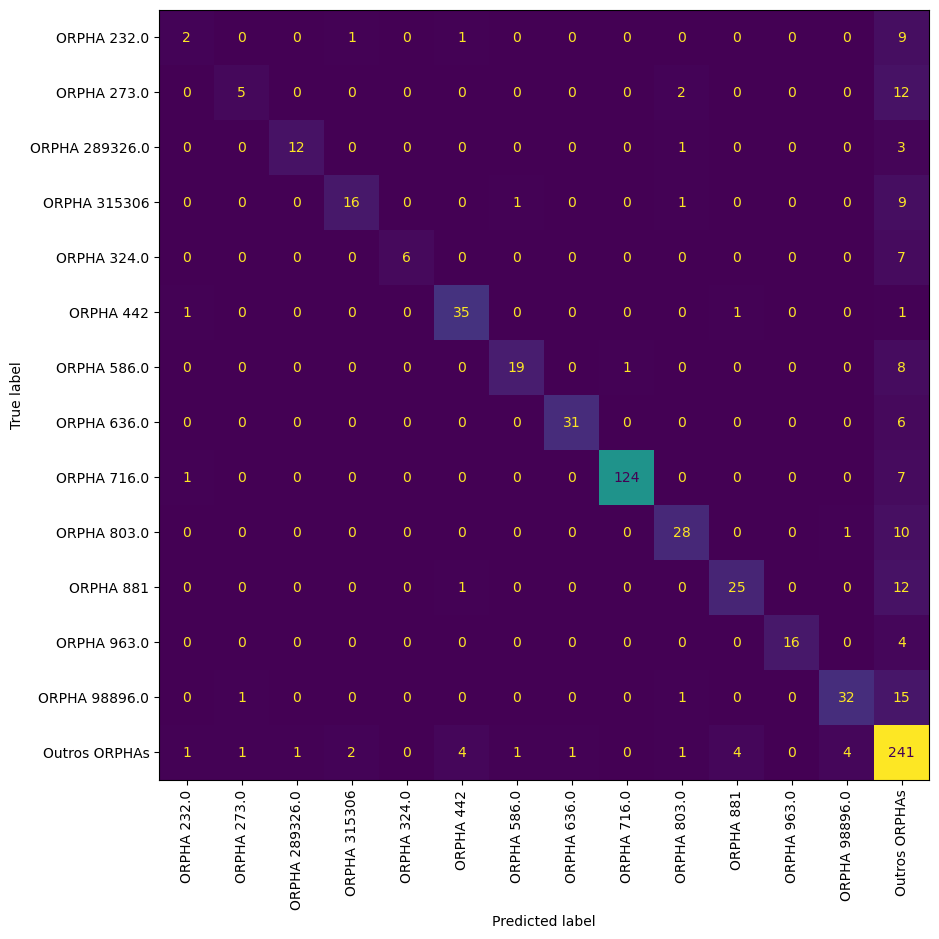

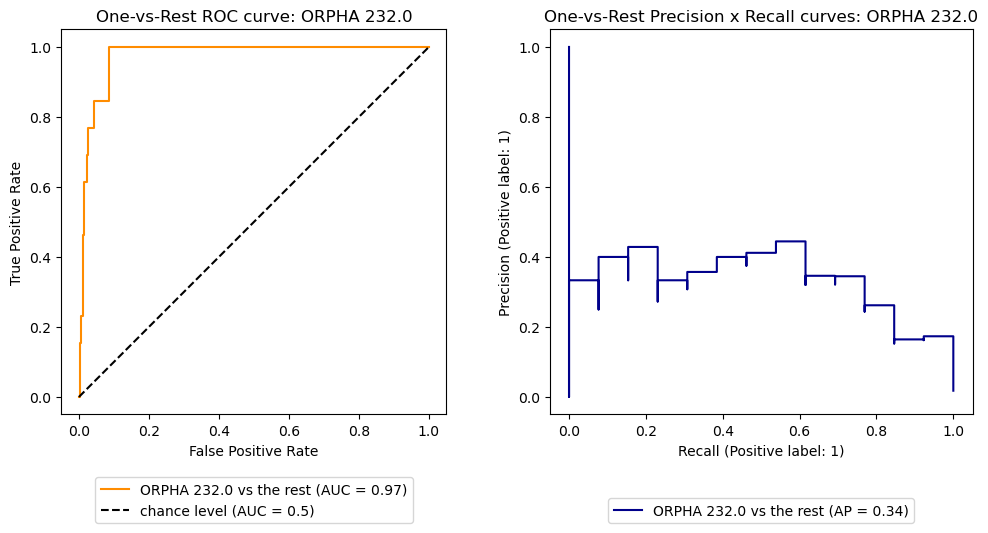

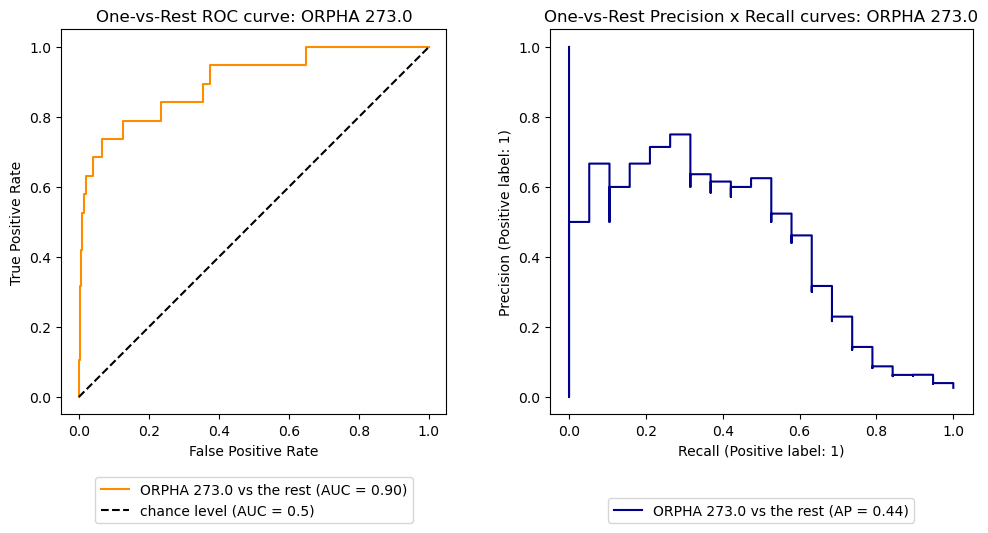

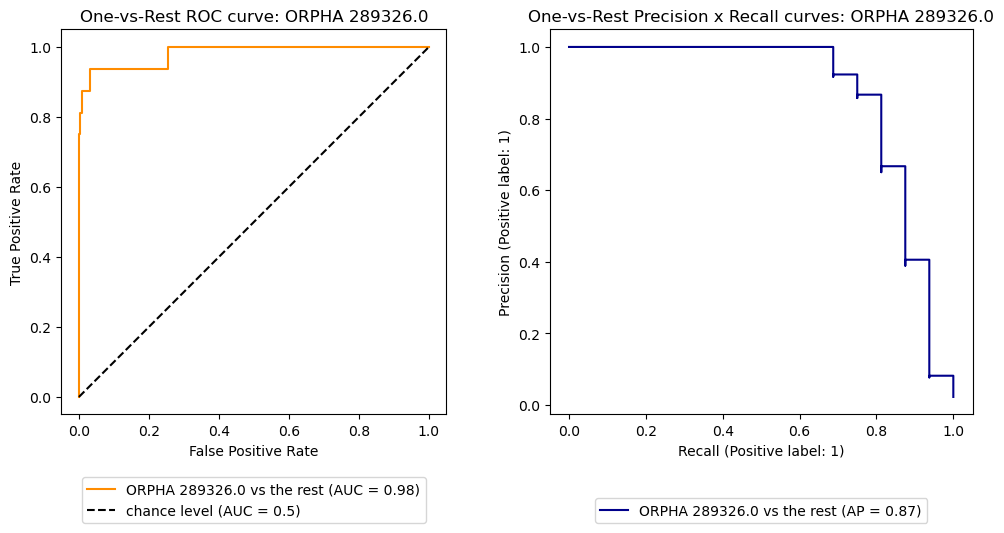

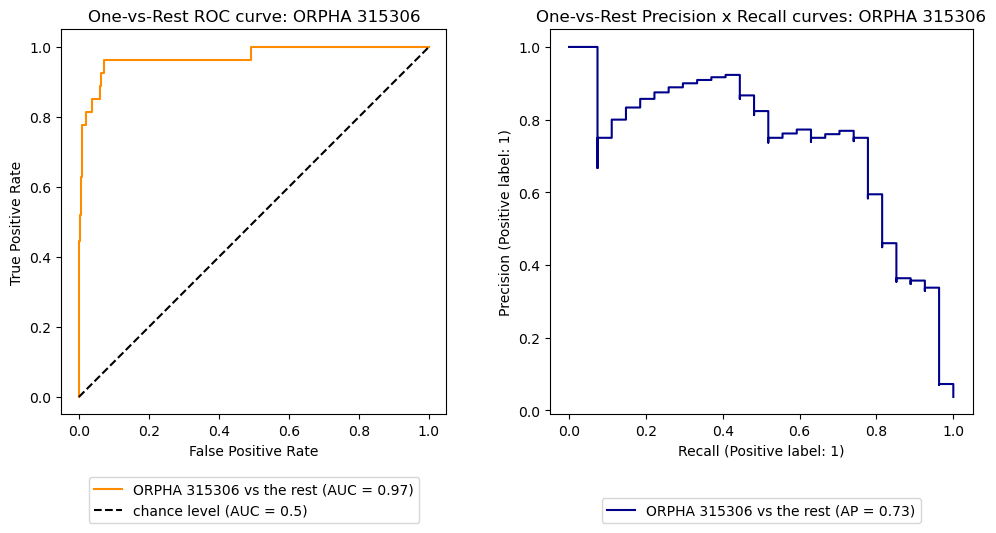

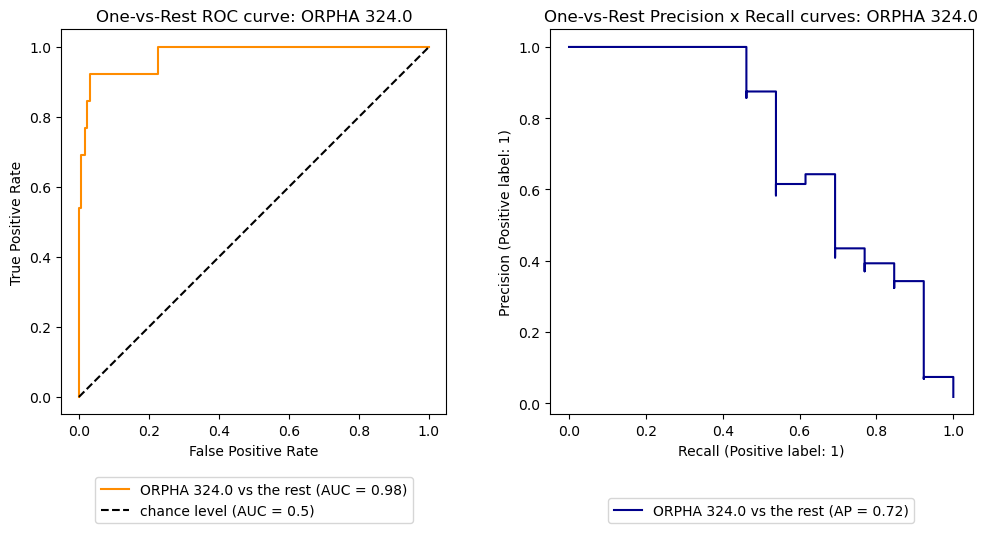

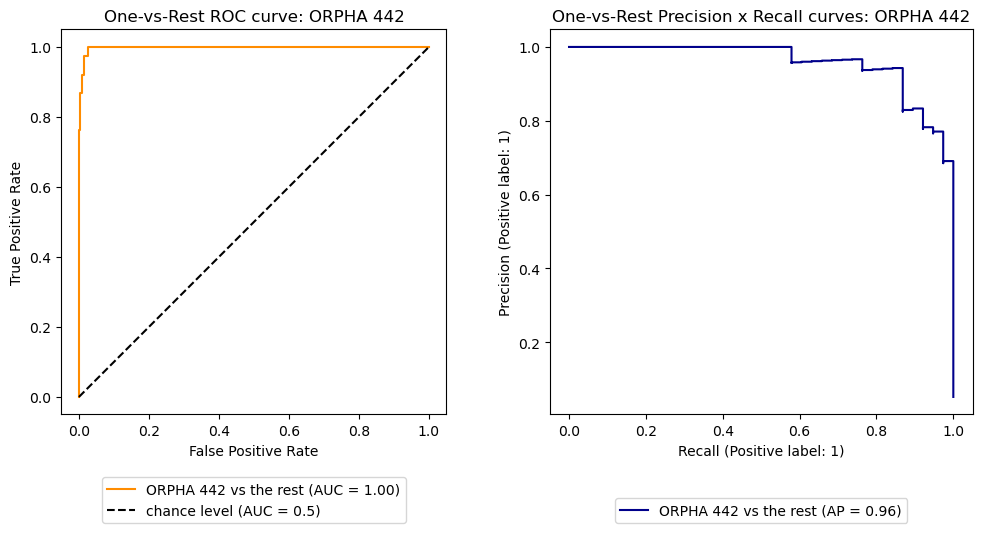

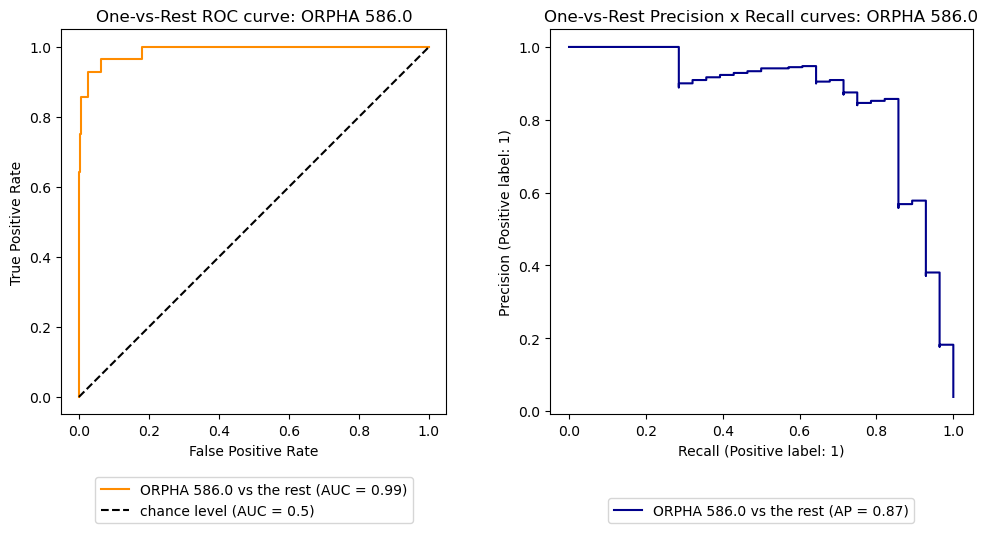

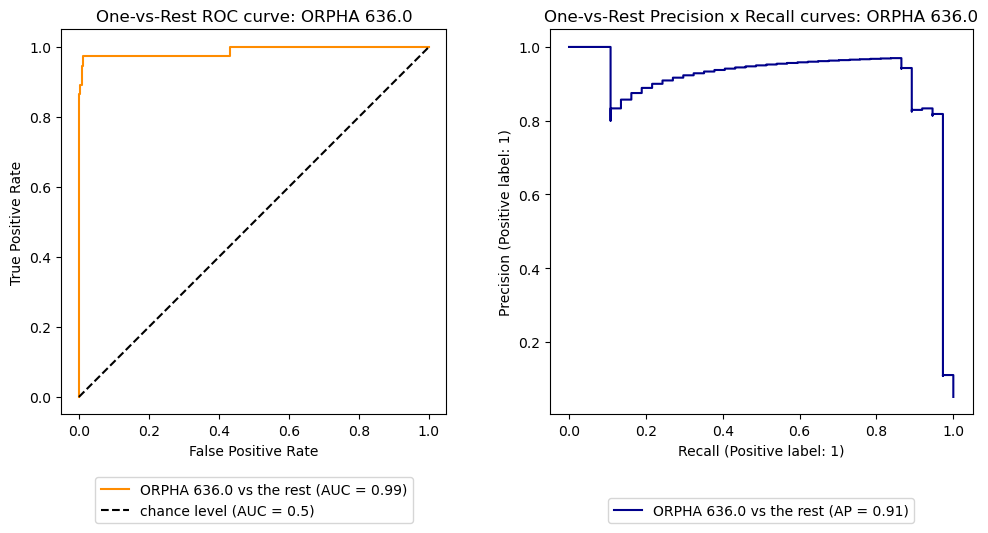

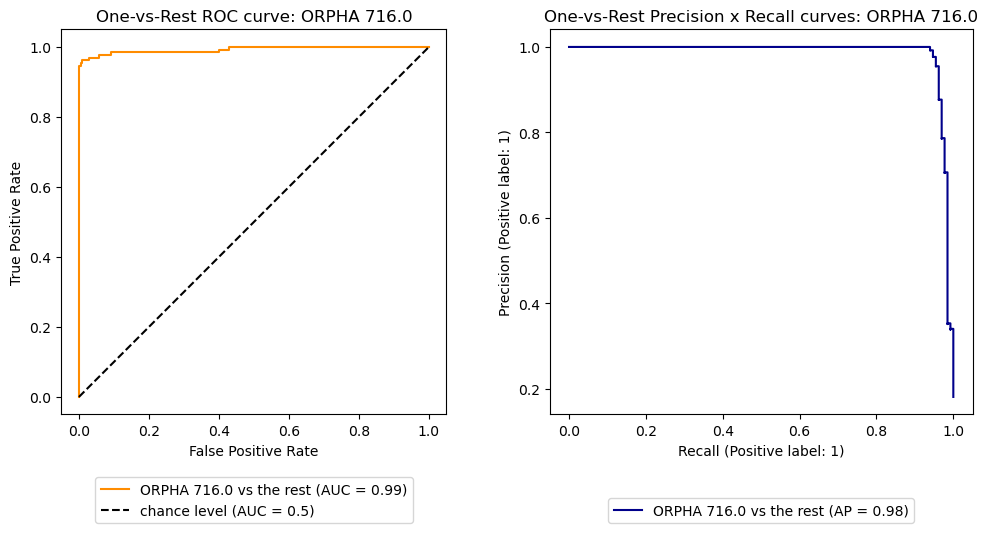

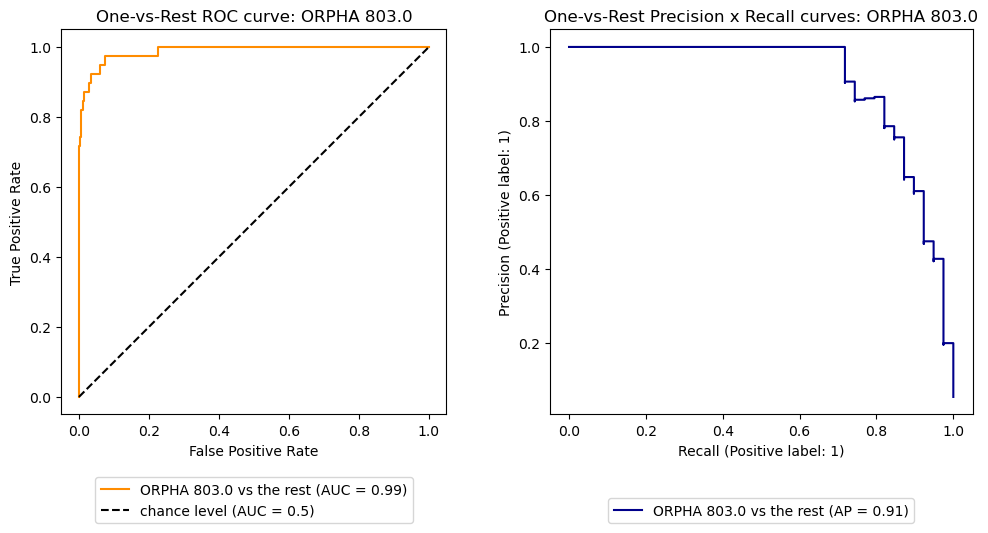

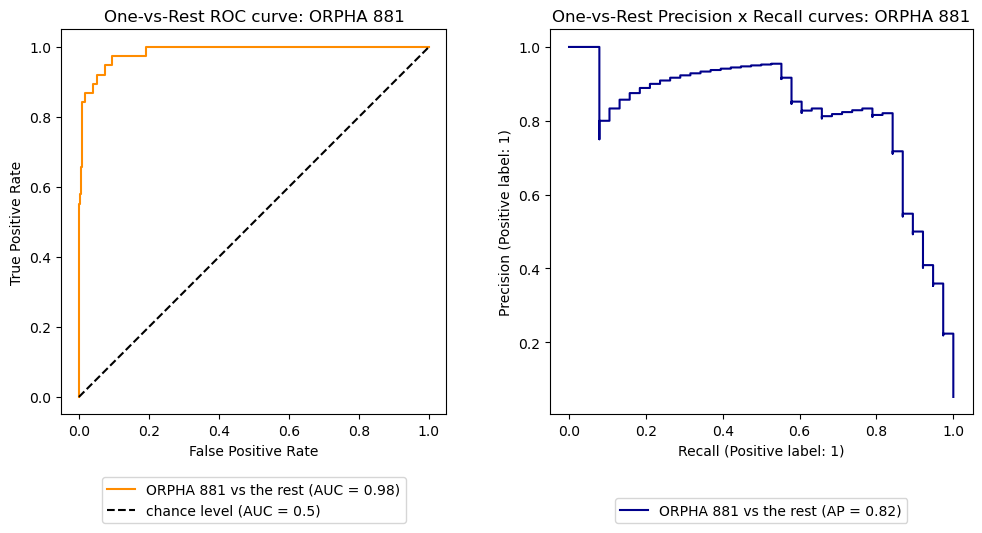

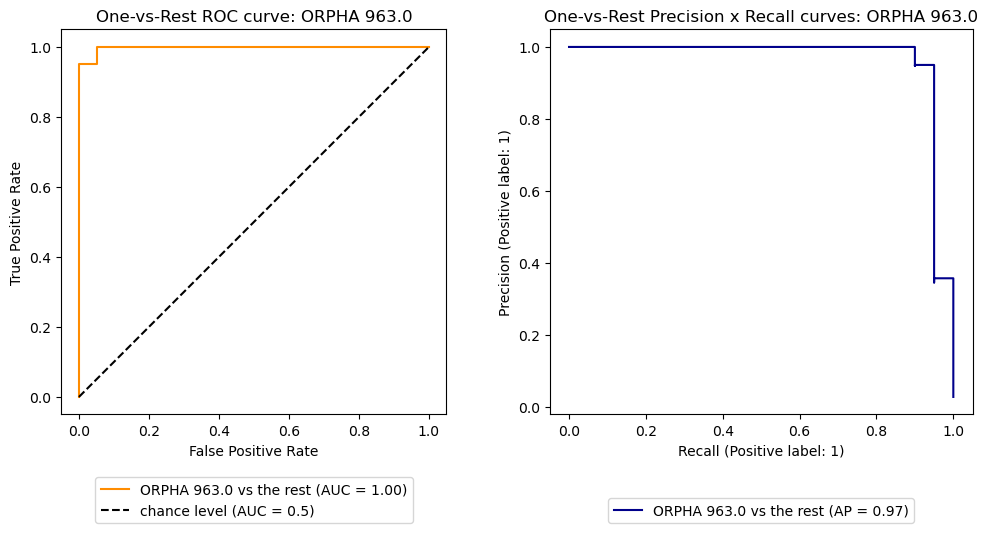

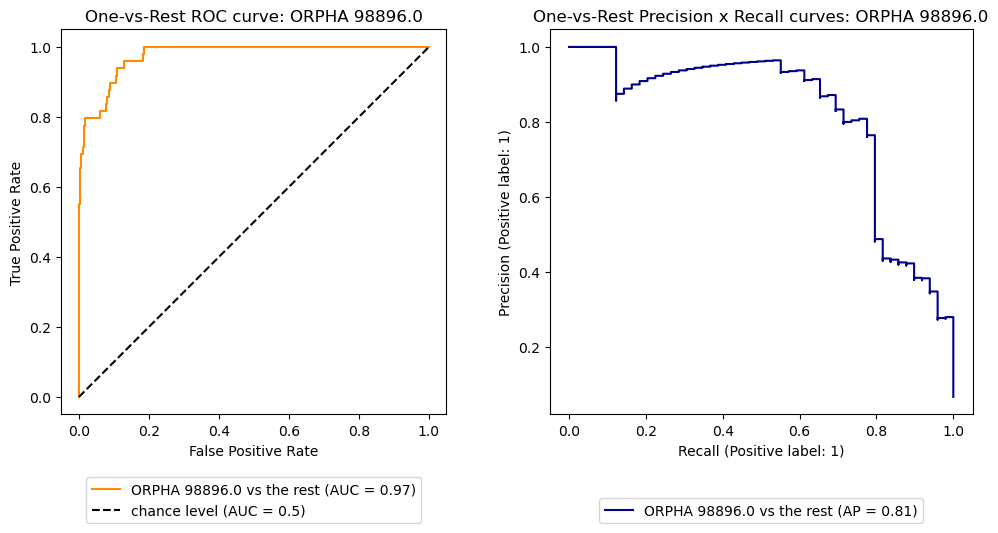

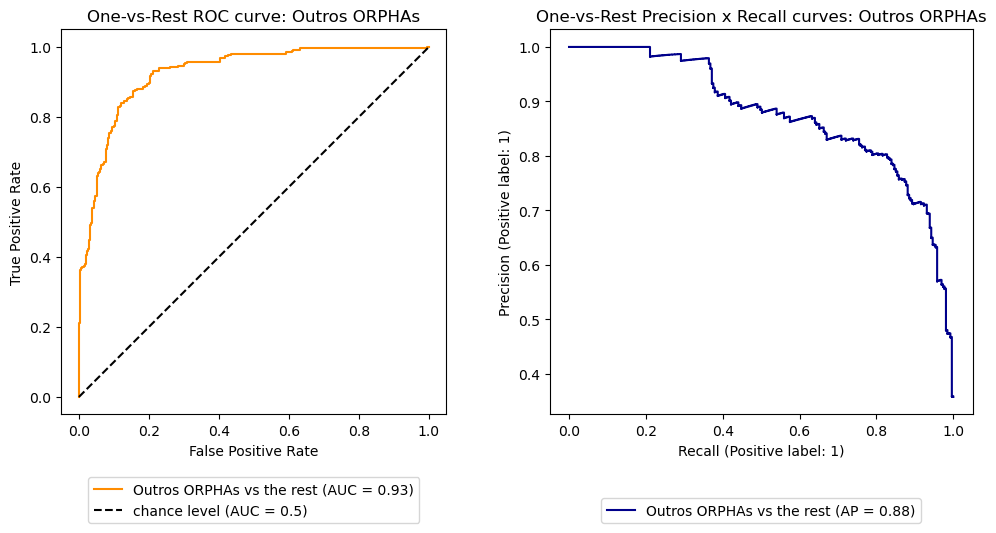

In [13]:
# TESTA DADOS DO CONJUNTO DE TESTE

# load the model from disk
loaded_model = joblib.load('models\\raras_grid_best_estimator_all.sav')

# resultados utilizando dados do prospectivo
print_model_metrics(loaded_model, X_test, y_test, "results_test")

Outros ORPHAs     1301
ORPHA 586.0         81
ORPHA 636.0         72
ORPHA 98896.0       50
ORPHA 442           47
ORPHA 881           43
ORPHA 716.0         41
ORPHA 803.0         26
ORPHA 273.0         11
ORPHA 963.0         10
ORPHA 315306         9
ORPHA 232.0          3
ORPHA 324.0          2
ORPHA 289326.0       1
Name: diagnostico, dtype: int64
                precision    recall  f1-score   support

   ORPHA 232.0      1.000     0.333     0.500         3
   ORPHA 273.0      0.000     0.000     0.000        11
ORPHA 289326.0      0.000     0.000     0.000         1
  ORPHA 315306      0.333     0.333     0.333         9
   ORPHA 324.0      0.500     0.500     0.500         2
     ORPHA 442      0.643     0.191     0.295        47
   ORPHA 586.0      1.000     0.222     0.364        81
   ORPHA 636.0      0.956     0.597     0.735        72
   ORPHA 716.0      0.829     0.829     0.829        41
   ORPHA 803.0      0.778     0.808     0.792        26
     ORPHA 881      0.568    

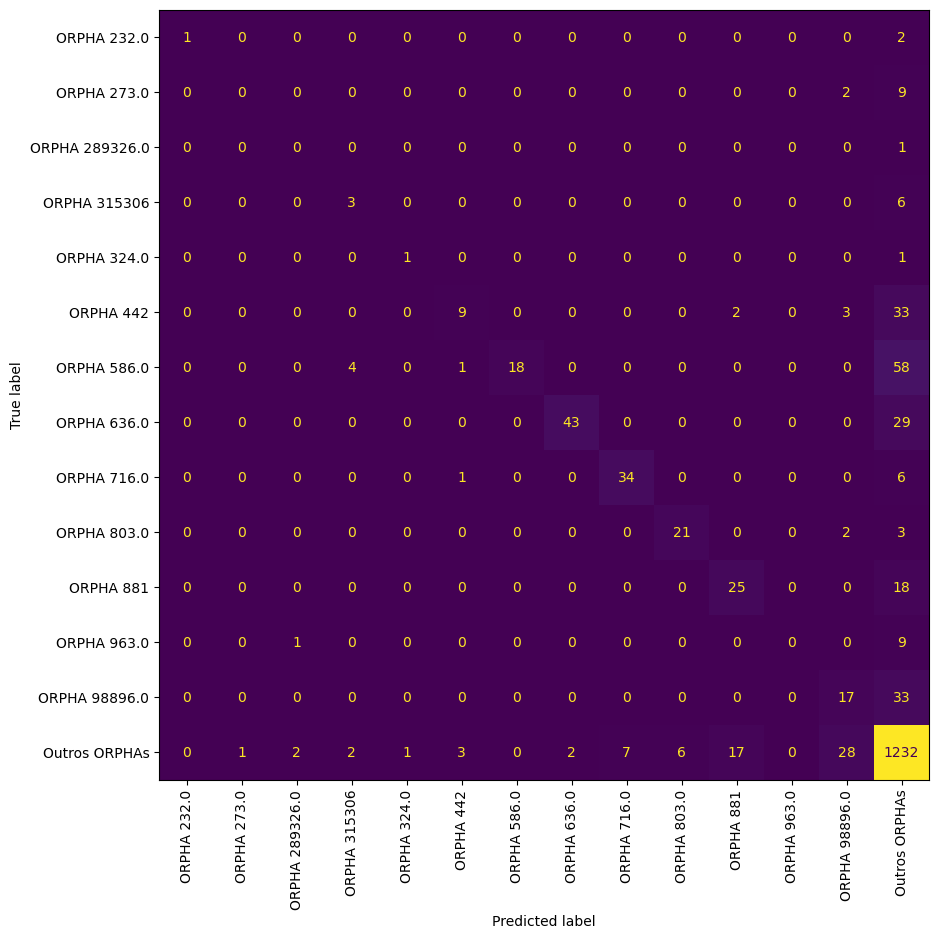

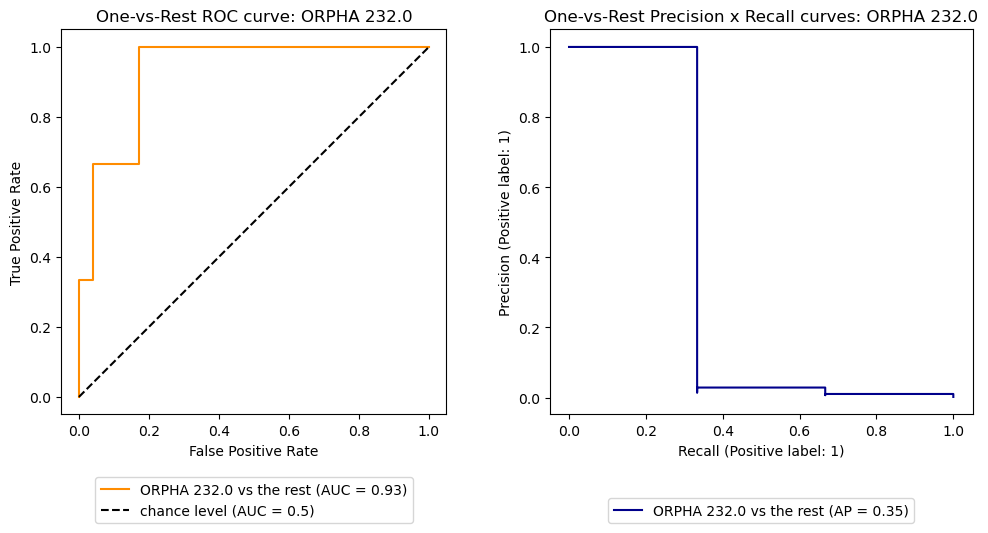

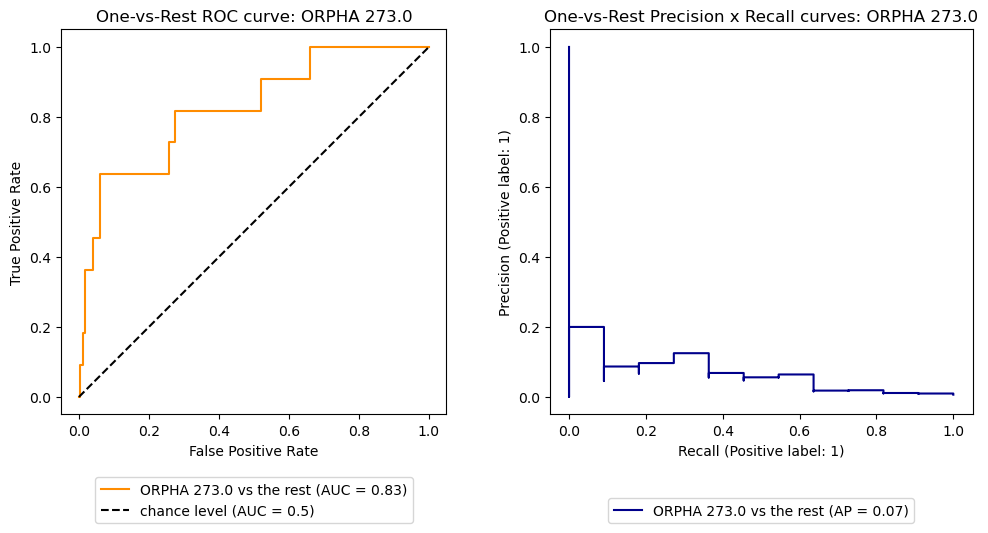

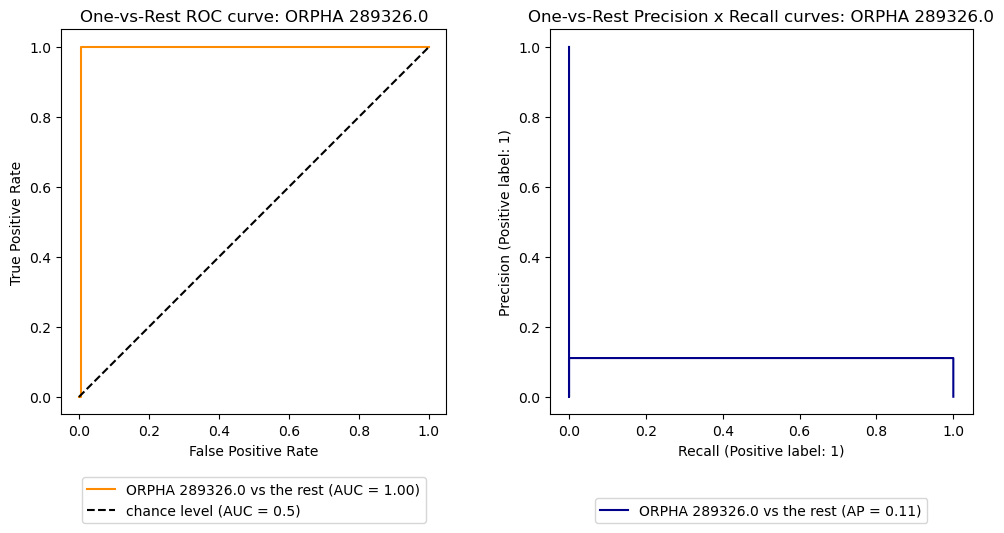

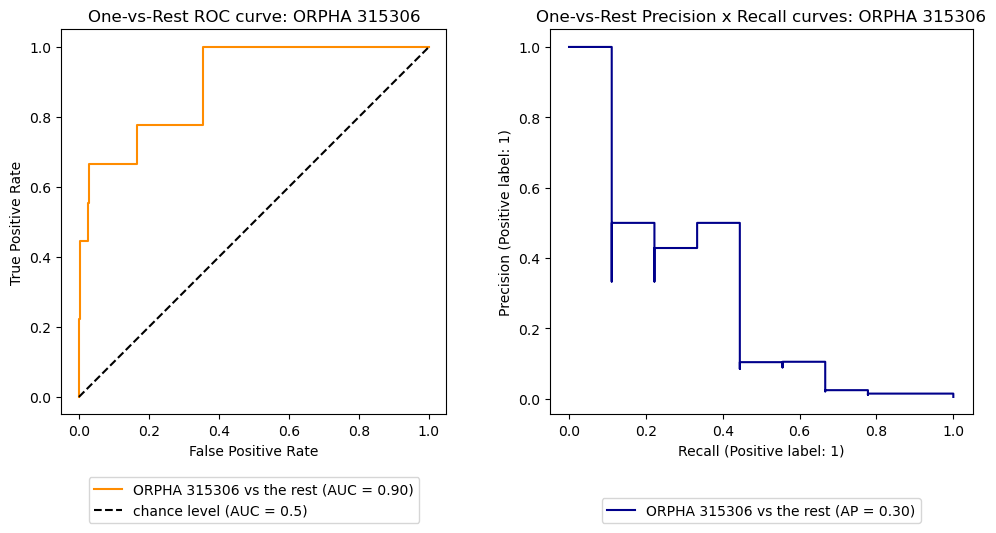

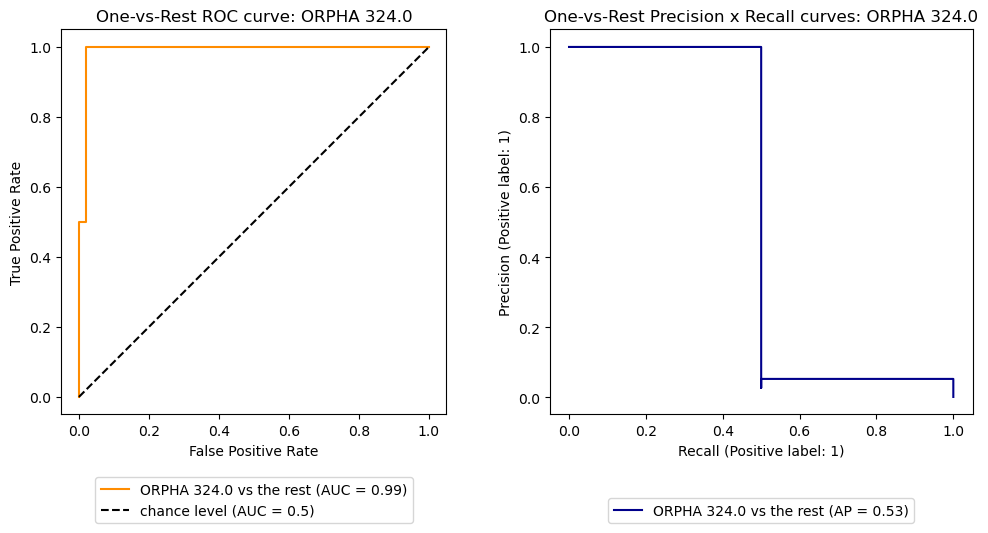

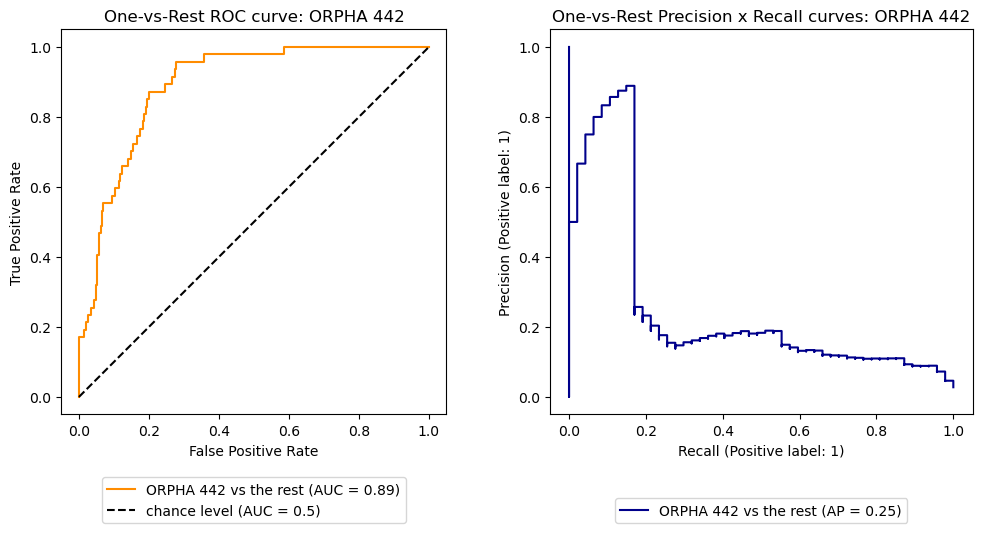

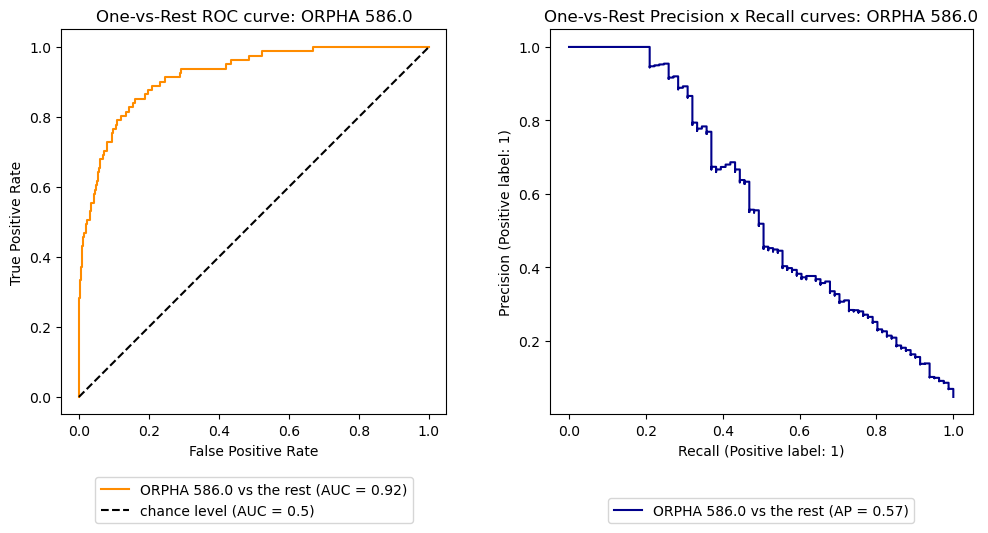

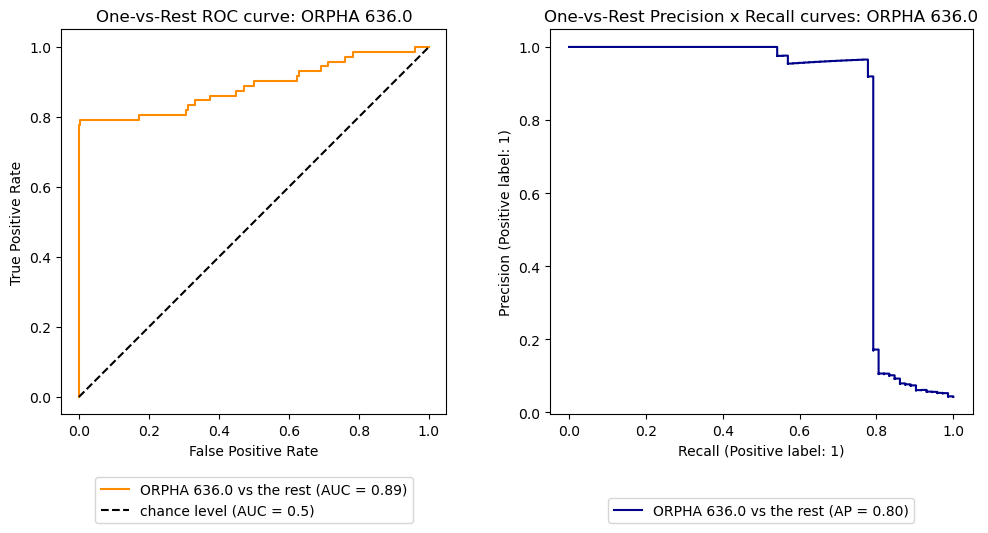

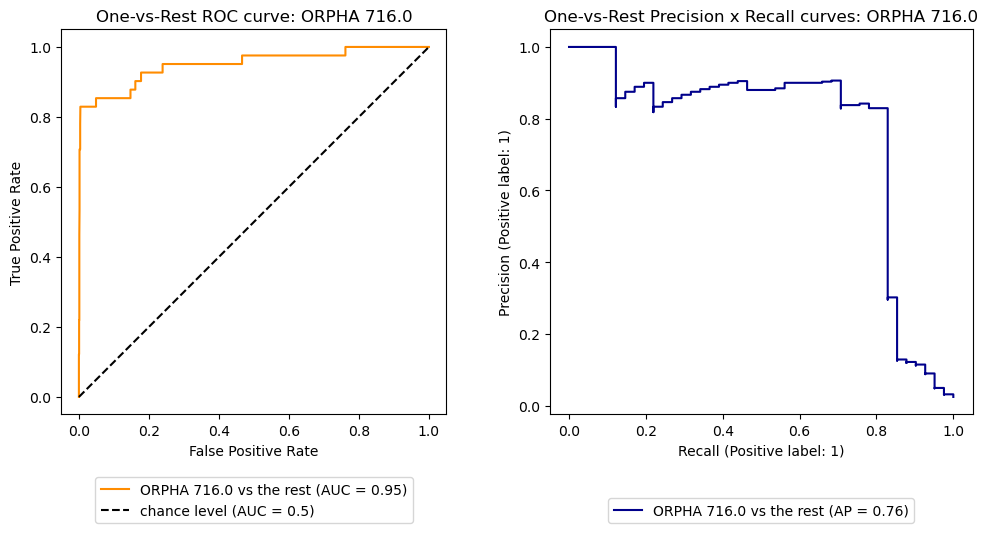

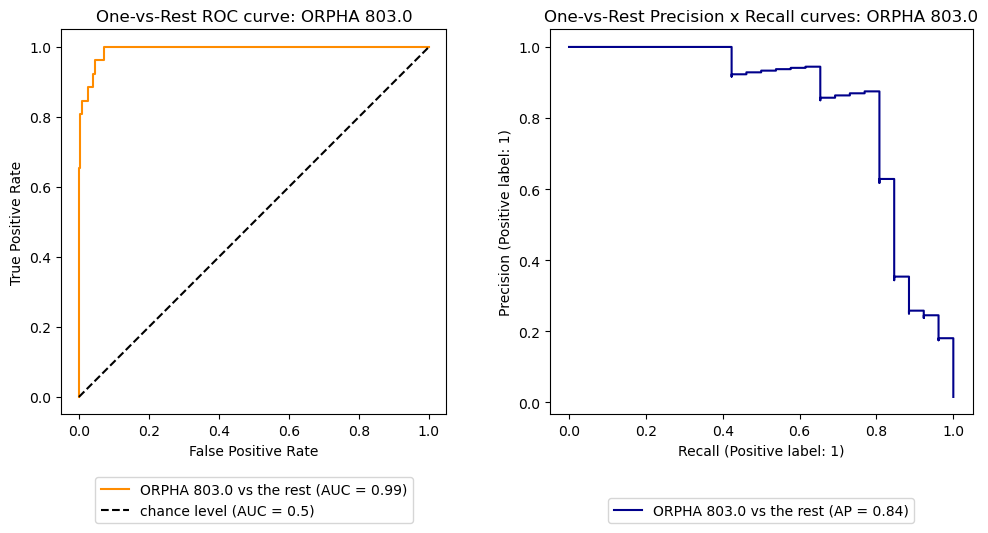

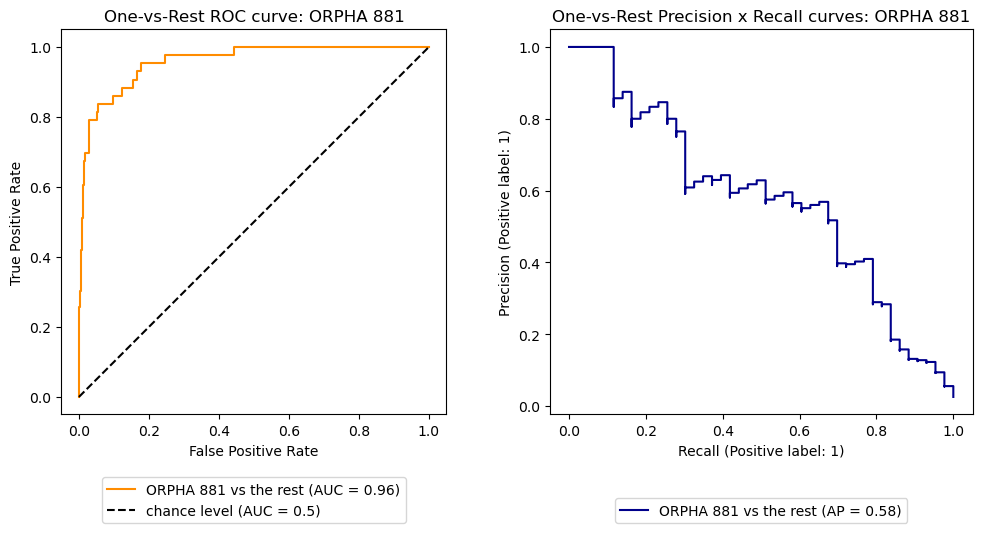

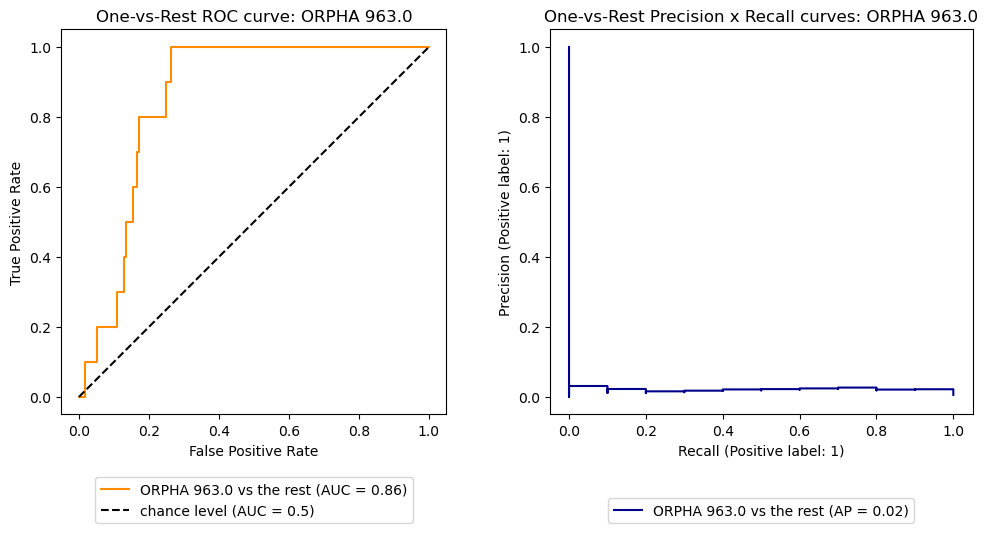

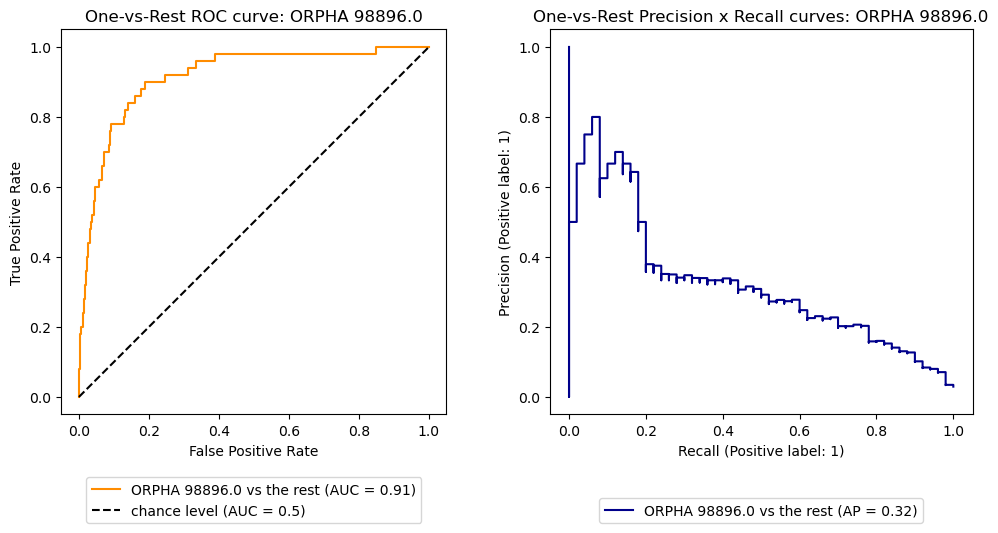

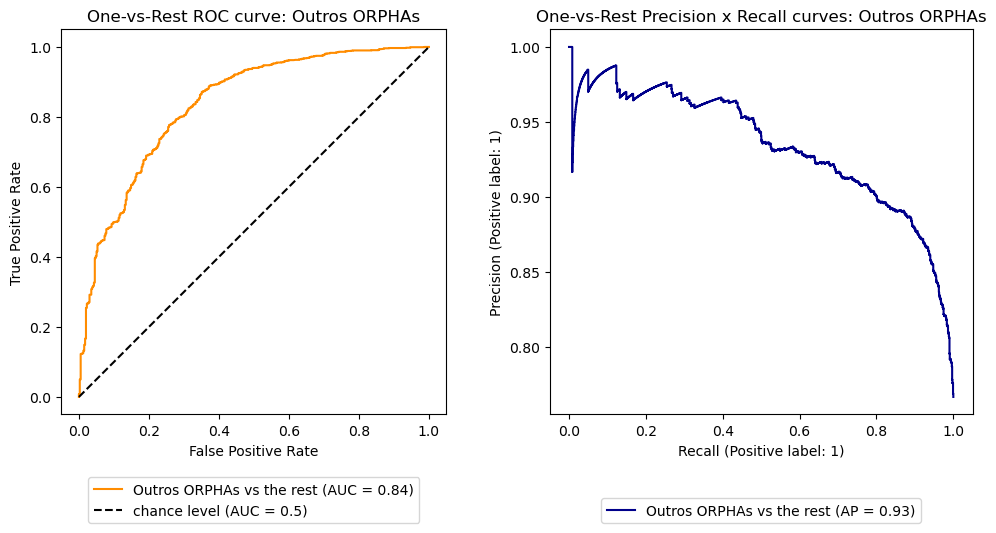

In [14]:
# TESTA DADOS DO PROSPECTIVO SOMENTE

# load the model from disk
loaded_model = joblib.load('models\\raras_grid_best_estimator_all.sav')

# carrega arquivo com dados filtrados do prospectivo
obj_raras_som_prosp_filtered = pd.read_csv(filepath_or_buffer='raras_prospectivo_filtered.csv', sep=';', converters={"hpos": lambda x: x.strip("[]").split(", ")})
obj_raras_som_prosp_filtered = obj_raras_som_prosp_filtered.drop('Unnamed: 0', axis=1) # isso ou salvar com index=False

# marcando como "outros" diagnósticos que não estavam no conjunto de treinamento
obj_raras_som_prosp_filtered.loc[obj_raras_som_prosp_filtered.diagnostico.isin(label_encoder.classes_) == False, ('diagnostico')] = 'Outros ORPHAs'

# extrai coluna de classe e aplica label encoder
y_som_prosp = obj_raras_som_prosp_filtered.diagnostico
y_som_prosp = label_encoder.transform(y_som_prosp)
X_som_prosp = obj_raras_som_prosp_filtered.drop(columns=['diagnostico'])

#print(label_encoder.inverse_transform(loaded_model.classes_))
#print(loaded_model.classes_.shape)
#print(label_encoder.classes_)
#print(label_encoder.classes_.shape)
print(obj_raras_som_prosp_filtered.diagnostico.value_counts())

# resultados utilizando dados do prospectivo
print_model_metrics(loaded_model, X_som_prosp, y_som_prosp, "results_validation")

In [16]:
# load the params from disk
loaded_params = joblib.load('models\\raras_grid_best_params_all.pkl')

print(loaded_params)

# carrega arquivo com dados filtrados do prospectivo
obj_raras_som_prosp_filtered = pd.read_csv(filepath_or_buffer='data\\raras_somente_prospectivo_filtered.csv', sep=';', converters={"hpos": lambda x: x.strip("[]").split(", ")})
obj_raras_som_prosp_filtered = obj_raras_som_prosp_filtered.drop('Unnamed: 0', axis=1) # isso ou salvar com index=False

# marcando como "outros" diagnósticos que não estavam no conjunto de treinamento
obj_raras_som_prosp_filtered.loc[obj_raras_som_prosp_filtered.diagnostico.isin(label_encoder.classes_) == False, ('diagnostico')] = 'Outros ORPHAs'

print(obj_raras_som_prosp_filtered.diagnostico.value_counts())
print(obj_raras_som_prosp_filtered.diagnostico.value_counts(normalize=True))
print(obj_raras_som_prosp_filtered.shape)

{'preprocessing_ct__numeric_pipe__scaler': MinMaxScaler(), 'preprocessing_ct__numeric_pipe__replacer': NanReplacer(), 'preprocessing_ct__numeric_pipe': Pipeline(steps=[('scaler', MinMaxScaler()), ('replacer', NanReplacer())]), 'preprocessing_ct__multilabel_bin': MultiHotEncoder(), 'preprocessing_ct__categorical_pipe__imputer__strategy': 'most_frequent', 'preprocessing_ct__categorical_pipe__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessing_ct__categorical_pipe': Pipeline(steps=[('one_hot',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                ('clean_columns', ColunmCleaner()),
                ('imputer', SimpleImputer(strategy='most_frequent'))]), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__l1_ratio': 0.9, 'classifier__class_weight': None, 'classifier__C': 1, 'classifier': LogisticRegression(C=1, l1_ratio=0.9, solver='saga')}
Outros ORPHAs     1301
ORPHA 586.0         81
ORPHA 636.0         72
ORPHA 98